# 5. Explore communication by exRNA

Transcripts located outside segmented cells are more likely to play a role in celular communication, being located outside their cell of origin and close to other populations. Thus, in the following notebook we aim to explore the commnunication patterns where exRNA could be involved

## Import packages

In [ ]:
import spatialdata as sd

import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Read SpatialData object

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

# 1. Identify source cell of exRNA

We will use the function `compute_source_cells` to identify the source cell types that may contribute to the extracellular RNA detected in spatial transcriptomics data. For this, we use an expression threshold to determine which transcripts are expressed and computes the proportion of cells expressing each gene per cell type.

In [ ]:
troutpy.tl.compute_source_score(sdata, layer="transcripts", gene_key="feature_name", lambda_decay=0.1, copy=False, celltype_key="cell type")

We can plot the aggregated source cell type by gene using ``troutpy.pl.source_score_by_celltype``


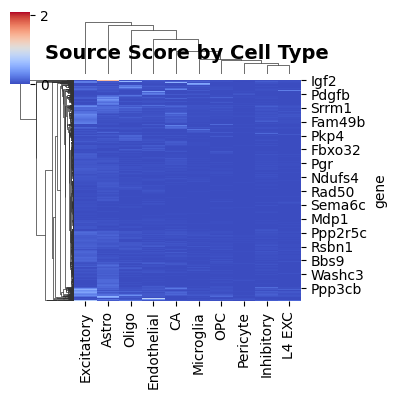

In [5]:
troutpy.pl.source_score_by_celltype(sdata, figsize=(4, 4))

### 1.1 Compute distance to source cell

After computing the distance between each cell and its source, we can quantify the proportion of extracellular transcripts located away (distant transcripts) from its closest source. For this, we define a threshold distance ( in micrometers), which will be the minimum distance from each transcript to its source to consider a transcript distance. To compute the proportion of distant transcripts, we will employ the function ``troutpy.tl.compute_distant_cells_prortion``

In [31]:
troutpy.tl.compute_distant_cells_proportion(sdata, gene_id_column="feature_name", threshold=30, copy=False)

Originally we developed a function to plot this, but we could use the same one as we expect to develop to quantify RNA. Specifically
 
**PLOTTING FUNCTION 2 (troutpy.pl) Sorted scatterplot/barplot**

In [ ]:
# Compute contribution source score

In [ ]:
import numpy as np


def compute_projection_score(sdata):
    """
    Compute a segmentation score for each cell based on the expression of genes weighted by their intracellular proportion (1 - extracellular proportion).

    Parameters
    ----------
    sdata : dict
        A spatialdata object with keys 'table' and 'xrna_metadata'.
        - sdata['table'] is an AnnData object containing expression data in layers['raw']
          and cell metadata in .obs.
        - sdata['xrna_metadata'].var is a DataFrame with gene names as the index and
          an 'extracellular proportion' column.

    Returns
    -------
    sdata : dict
        The same sdata object with a new column 'segmentation_score' in sdata['table'].obs.
    """
    # Retrieve the AnnData object with cells in .obs and genes in .var
    adata = sdata["table"]

    # Retrieve raw expression data; assume shape (n_cells, n_genes)
    raw_expr = adata.layers["raw"]

    # If raw_expr is a sparse matrix, convert to a dense array
    if hasattr(raw_expr, "toarray"):
        raw_expr = raw_expr.toarray()

    # Get gene names from the AnnData object
    genes = adata.var_names

    # Retrieve gene metadata containing the extracellular proportions
    gene_meta = sdata["xrna_metadata"].var

    # Identify the genes common to both the expression data and the metadata
    common_genes = gene_meta.index.intersection(genes)
    if len(common_genes) == 0:
        raise ValueError("No common genes found between adata and gene metadata.")

    # Subset the expression matrix to only those common genes
    # Here we assume adata.var_names preserves order; get indices corresponding to common genes.
    common_idx = [i for i, gene in enumerate(genes) if gene in common_genes]
    raw_expr = raw_expr[:, common_idx]

    # Reorder gene_meta so that it matches the ordering in the expression data.
    # This assumes that the order of genes in adata.var_names is the desired order.
    ordered_genes = [gene for gene in genes if gene in common_genes]
    gene_weights = gene_meta.loc[ordered_genes, "extracellular_proportion"]

    # Convert extracellular proportion to intracellular weight (1 - extracellular proportion)
    intracellular_weights = 1 - gene_weights.values  # numpy array

    # Compute the numerator and denominator for the weighted average per cell.
    # Numerator: dot product of cell expression with intracellular weights.
    # Denominator: total expression (for the common genes) per cell.
    numerator = raw_expr.dot(intracellular_weights)
    denominator = raw_expr.sum(axis=1)

    # Avoid division by zero (if a cell has zero expression for these genes)
    score = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)

    # Store the score in the AnnData object under obs
    adata.obs["projection_score"] = score

#   return sdata

# Example usage:
# sdata = compute_segmentation_score(sdata)

## 2. Identify target cell of each exRNA

Once we have explored the potential source cell of each extracellular transcript, we can also expore the most likely target cell of each exRNA analyzed. For this, we will employ ``troutpy.tl.compute_target_score``. Essentially, this function will compute the distance to its closest cells for each exRNA, using a decay function, based on lambda decay. Of course, we can't be sure that communication will occur with the closest cells. However, in case exRNA plays a role in cell-cell communication, the most likely target cell of each exRNA will be its closest cell. 

In [ ]:
troutpy.tl.compute_target_score(
    sdata,
    layer="transcripts",
    gene_id_column="feature_name",
    xcoord="x",
    ycoord="y",
    xcellcoord="x_centroid",
    ycellcoord="y_centroid",
    lambda_decay=0.1,
    copy=False,
    celltype_key="cell type",
)

For representing the target cell scores,  we could use the plotting function ``troutpy.pl.source_score_by_celltype(sdata)``

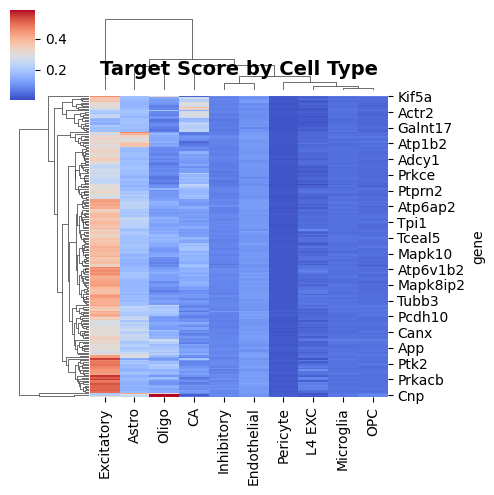

In [ ]:
troutpy.pl.target_score_by_celltype(sdata, figsize=(5, 5))

### 2.1 Saving sdata as .zarr

We next save the object as zarr

In [31]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr). Please see   
         the documentation of `is_self_contained()` to understand the implications of working with SpatialData     
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr the new file path:                 
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr                                  


# 3. Communication 

After we have computed source and target scores, we can explore communication. For this, we will compute the possibility of interaction, per extracellular transcript. This is step is achieved using ```troutpy.tl.compute_communication_strength```. Results are stored under ```sdata['source_score'].uns['interaction_strenght']``` and is a 3D matrix, where we have the communication scores for each transcript and each pair of cell types (exRNA,CT,CT)
*the location of this is temporary until we find a better place to store it*

In [27]:
troutpy.tl.compute_communication_strength(sdata)

100%|█████████████████████████████████████████████████████████████████████████| 834299/834299 [03:51<00:00, 3607.83it/s]


Next, we will compile all scores by gene (G), using ```troutpy.tl.gene_specific_interactions```. The resulting 3D matrix (G,CT,CT), will be stored in ```sdata['source_score'].uns['gene_interaction_strenght']```. Gene names corresponding to the first dimension will be stored in ```sdata['source_score'].uns['gene_interaction_names']```

In [29]:
troutpy.tl.gene_specific_interactions(sdata, copy=False)

Processing categories: 100%|████████████████████████████████████████████████████████| 5566/5566 [14:23<00:00,  6.44it/s]



We first visualize the overall communication using ``troutpy.pl.celltype_interactions``

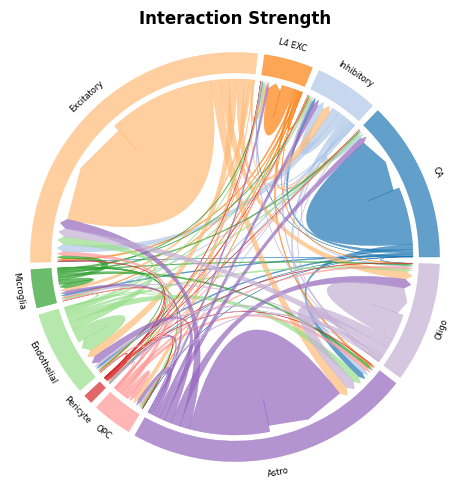

In [3]:
troutpy.pl.celltype_communication(sdata, kind="chord", celltype_key="cell type", figsize=(4, 4))

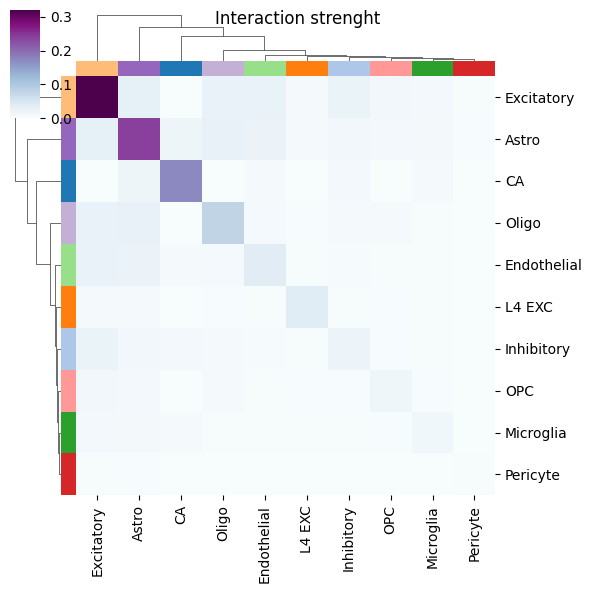

In [4]:
troutpy.pl.celltype_communication(sdata, kind="heatmap", celltype_key="cell type", figsize=(6, 6))

We can also plot the gene-specific communication patterns

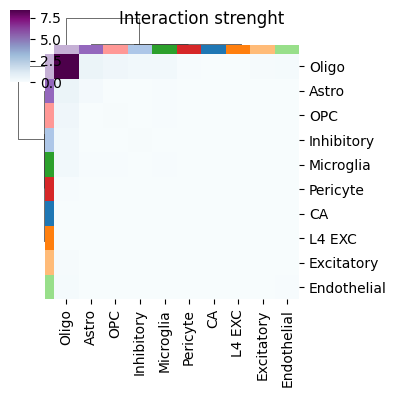

In [ ]:
troutpy.pl.gene_communication(sdata, kind="heatmap", gene="Cnp", figsize=(4, 4))